# Predicción mediante técnicas de IA - Trabajo final - Cuaderno de construcción de modelos predictivos

Realizado por

* Manuel Alejandro De la Rosa Gómez
* Diego Alejandro Campuzano Botero
* Gabriel Jaime Orrego Restrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import keras_tuner as kt

In [3]:
df=pd.read_csv('81_datos_procesados.csv')

In [4]:
df.columns

Index(['fecha_hora', 'Humedad_mean', 'Presion_mean', 'Temperatura_mean',
       'Velocidad_mean', 'Direccion_mean', 'Precipitacion_mean', 'PM25',
       'Humedad_mean_lag1', 'Humedad_mean_lag2', 'Humedad_mean_lag3',
       'Humedad_mean_lag4', 'Humedad_mean_lag5', 'Humedad_mean_lag6',
       'Humedad_mean_lag12', 'Humedad_mean_lag24', 'Temperatura_mean_lag1',
       'Temperatura_mean_lag2', 'Temperatura_mean_lag3',
       'Temperatura_mean_lag4', 'Temperatura_mean_lag5',
       'Temperatura_mean_lag6', 'Temperatura_mean_lag12',
       'Temperatura_mean_lag24', 'Presion_mean_lag1', 'Presion_mean_lag2',
       'Presion_mean_lag3', 'Presion_mean_lag4', 'Presion_mean_lag5',
       'Presion_mean_lag6', 'Presion_mean_lag12', 'Presion_mean_lag24',
       'Velocidad_mean_lag1', 'Velocidad_mean_lag2', 'Velocidad_mean_lag3',
       'Velocidad_mean_lag4', 'Velocidad_mean_lag5', 'Velocidad_mean_lag6',
       'Velocidad_mean_lag12', 'Velocidad_mean_lag24', 'Direccion_mean_lag1',
       'Direccion_m

In [5]:
# features = [
#     'no',
#     'no2',
#     'nox',
#     'dviento_ssr',
#     'haire10_ssr',
#     'p_ssr',
#     'rglobal_ssr',
#     'taire10_ssr',
#     'vviento_ssr'
#     ]

features = [
    'Humedad_mean',
    'Presion_mean',
    'Temperatura_mean',
    'Velocidad_mean',
    'Direccion_mean',
    'Precipitacion_mean'
]

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop(['fecha_hora'], axis=1, inplace=True)

In [9]:
df['PM25'].describe()

count    49162.000000
mean        12.086014
std          7.492992
min          0.500000
25%          6.939005
50%         10.477750
75%         15.679488
max         39.990400
Name: PM25, dtype: float64

# Verificación de variables numéricas

## Variable objetivo

<Axes: >

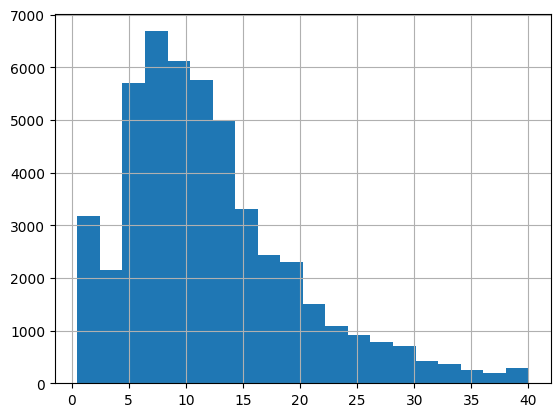

In [11]:
df['PM25'].hist(bins=20)

## Otros contaminantes

In [35]:
df['no'].describe()

count    61344.000000
mean        15.857095
std         16.917607
min          0.000694
25%          3.801325
50%          9.713706
75%         22.360675
max        119.885000
Name: no, dtype: float64

<Axes: >

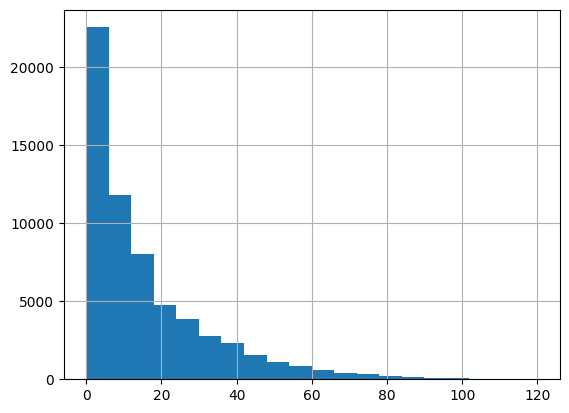

In [36]:
df['no'].hist(bins=20)

<Axes: >

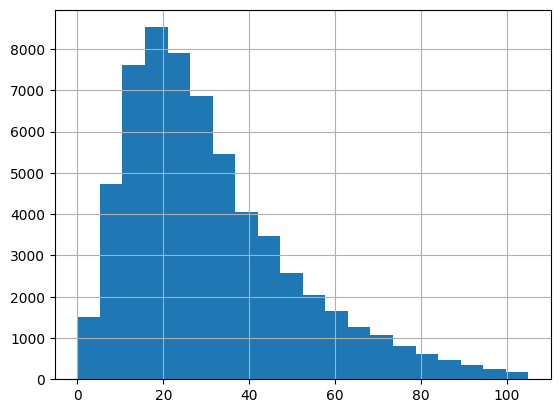

In [37]:
df['nox'].hist(bins=20)

# Particion de los datos

In [12]:
y=df['PM25']
X=df.drop('PM25', axis=1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Modelo de Random Forest

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), X_train.columns)])

In [15]:
pipeline=Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor())])

In [16]:
param_grid = {
    # 'n_estimators': np.arange(10,210,10),
    'regressor__n_estimators': [250],
    'regressor__max_depth': [150],
    'regressor__criterion': ['squared_error']
}

In [18]:
#Realizamos la busqueda de los hiperparametros
RF_gridSearch = GridSearchCV(
    pipeline, 
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',  
    n_jobs=-1,
    verbose=2)
RF_gridSearch.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Humedad_mean', 'Presion_mean', 'Temperatura_mean', 'Velocidad_mean',
       'Direccion_mean', 'Precipitacion_mean', 'Humedad_mean_lag1',
       'Humedad_mean_lag2', 'Humedad_mean_lag3', 'Humedad_mean_lag4',
       'Humedad_mean_lag5', 'Humedad_mean_lag6', 'Hum...
       'Precipitacion_mean_lag12', 'Precipitacion_mean_lag24', 'PM25_lag1',
       'PM25_lag2', 'PM25_lag3', 'PM25_lag4', 'PM25_lag5', 'PM25_lag6',
       'PM25_lag12', 'PM25_lag24'],
      dtype='object'))])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['squared_error'],
                         'regressor__max_depth': [150],
                         'regressor__n_estimators': [250]},
             scoring='neg_mean_squared_error', verbose=2)

In [19]:
best_estimator = RF_gridSearch.best_estimator_

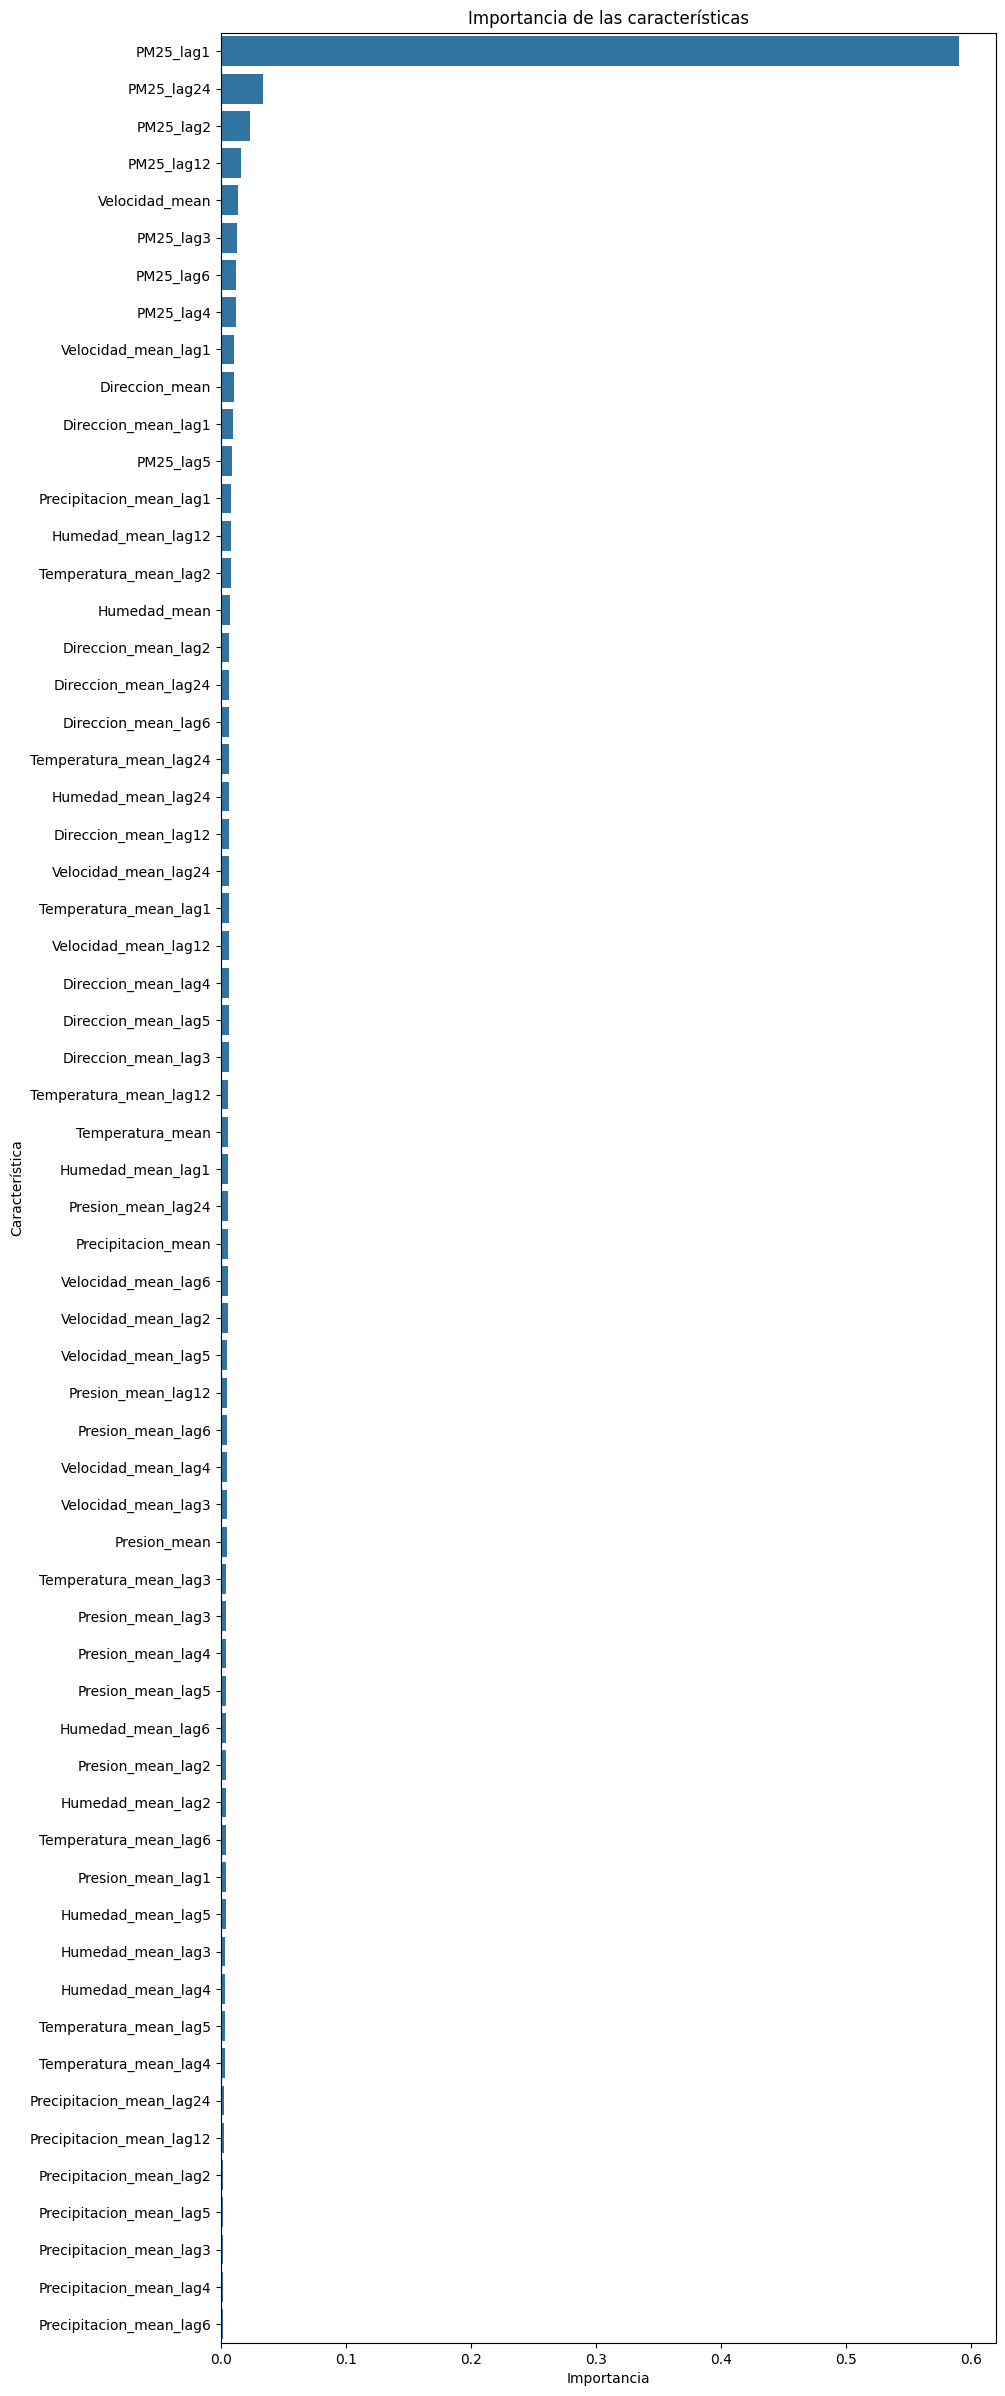

In [20]:
# Feature importance
importances = best_estimator.named_steps['regressor'].feature_importances_
# DataFrame con importancias
importances_df = pd.DataFrame(importances, index=X_train.columns, columns=['Importancia'])
# Ordenar importancias
importances_df = importances_df.sort_values(by='Importancia', ascending=False)
# Gráfico de barras
plt.figure(figsize=(10, 30))
sns.barplot(x='Importancia', y=importances_df.index, data=importances_df)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.show()

In [21]:
importances_df.head(10)

,Importancia
PM25_lag1,0.590679
PM25_lag24,0.033982
PM25_lag2,0.023619
PM25_lag12,0.015693
Velocidad_mean,0.013462
PM25_lag3,0.013222
PM25_lag6,0.012468
PM25_lag4,0.012298
Velocidad_mean_lag1,0.010723
Direccion_mean,0.010679


In [22]:
y_pred = best_estimator.predict(X_test)

In [23]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

MSE: 18.06961350391358
RMSE: 4.250836800432778
R2: 0.6806145026371679


((array([-3.68849506, -3.45633853, -3.32854287, ...,  3.32854287,
          3.45633853,  3.68849506]),
  array([-18.00058945, -16.38945419, -15.8738375 , ...,  24.99707546,
          26.40952317,  31.12406363])),
 (np.float64(4.211168883400768),
  np.float64(-0.0788733122195302),
  np.float64(0.9902893272390679)))

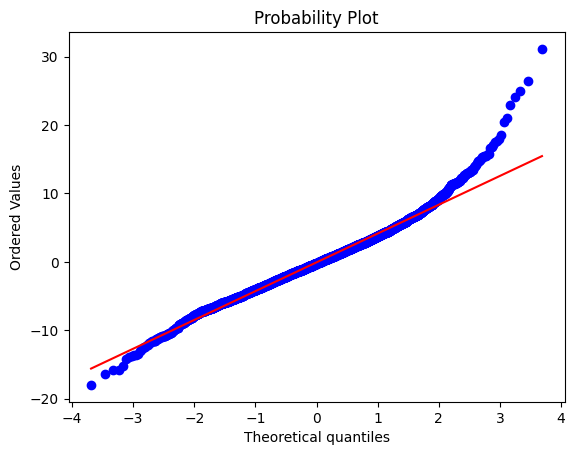

In [24]:
# Do the errors follow a normal distribution?
errors = y_test - y_pred
# Plot the QQ plot
stats.probplot(errors, dist="norm", plot=plt)

# Modelo de red neuronal

In [25]:
# Apply manually the preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
X_val_preprocessed = preprocessor.transform(X_val)

In [26]:
def model_builder(hp):
    # Se crea un modelo secuencial
    model = tf.keras.models.Sequential()
    # Se agrega una capa de entrada
    model.add(tf.keras.layers.InputLayer(input_shape=X_train_preprocessed.shape[1:]))
    # Se optimiza el número de capas ocultas
    n_layers = hp.Int('num_hidden_layers', min_value=2, max_value=6)
    # Optimize regularization parameters
    regularizer_choice = hp.Choice('regularizer', values=['none', 'l1', 'l2', 'l1_l2'])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    
    # Get regularizer based on choice
    if regularizer_choice == 'l1':
        regularizer = tf.keras.regularizers.L1(hp.Float('l1_value', min_value=1e-4, max_value=1e-2))
    elif regularizer_choice == 'l2':
        regularizer = tf.keras.regularizers.L2(hp.Float('l2_value', min_value=1e-4, max_value=1e-2))
    elif regularizer_choice == 'l1_l2':
        regularizer = tf.keras.regularizers.L1L2(
            l1=hp.Float('l1_l1l2_value', min_value=1e-4, max_value=1e-2),
            l2=hp.Float('l2_l1l2_value', min_value=1e-4, max_value=1e-2)
        )
    else:
        regularizer = None
    # Se optimiza el número de neuronas por capa
    for i in range(n_layers):
        model.add(
            tf.keras.layers.Dense(
                units=hp.Int('units_' + str(i), min_value=10, max_value=100, step=10), 
                activation='relu',
                kernel_regularizer=regularizer
            )
        )
        if dropout_rate > 0.0:
            model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    # Se agrega la capa de salida
    model.add(tf.keras.layers.Dense(1))
    # Se optimiza el learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2])

    # Se compila el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate),
        loss='mean_squared_error'
    )

    return model

In [27]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [28]:
# Configure the tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='mlp_tuning',
    project_name='pm25_mlp'
)

c:\AQI_Predict\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [29]:
tuner.search(X_train_preprocessed, y_train, epochs=100, validation_data=(X_val_preprocessed, y_val), callbacks=[early_stopping_cb])

Trial 254 Complete [00h 00m 30s]
val_loss: 17.086776733398438

Best val_loss So Far: 16.451480865478516
Total elapsed time: 00h 41m 04s


In [30]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
mlp_history=model.fit(X_train_preprocessed, y_train, epochs=100, validation_data=(X_val_preprocessed, y_val), callbacks=[early_stopping_cb])
model.evaluate(X_test_preprocessed, y_test)

Epoch 1/100


c:\AQI_Predict\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - loss: 33.6675 - val_loss: 18.6705
Epoch 2/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 18.7495 - val_loss: 17.9661
Epoch 3/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 18.1107 - val_loss: 17.9084
Epoch 4/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 18.2805 - val_loss: 17.9926
Epoch 5/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 18.2254 - val_loss: 18.1191
Epoch 6/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 17.8646 - val_loss: 17.5252
Epoch 7/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 17.5463 - val_loss: 17.3502
Epoch 8/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 17.2003 - val_loss: 17.6555
Epoch 9/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 17.4741 - val_loss: 17.3837
Epoch 10/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - loss: 16.9846 - val_loss: 18.8571
Epoch 11/100
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 17.4170 - val_l

17.122243881225586

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,425 (48.54 KB)

 Trainable params: 4,141 (16.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,284 (32.36 KB)

In [32]:
# Evaluate on test set
test_loss = model.evaluate(X_test_preprocessed, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
y_pred = model.predict(X_test_preprocessed)

# Calculate the MSE, RMSE, and R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 17.1484
Test Loss: 17.122243881225586
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
Mean Squared Error: 17.1222
Root Mean Squared Error: 4.1379
R² Score: 0.6974


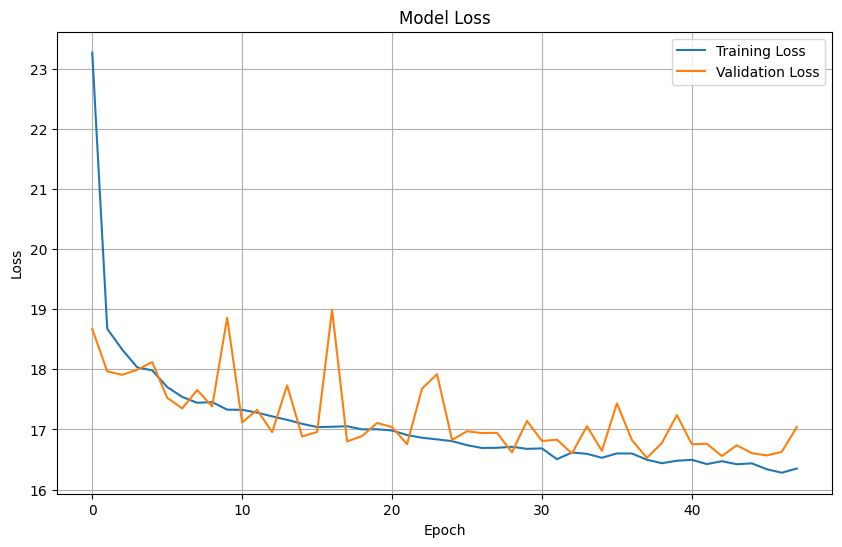

In [33]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

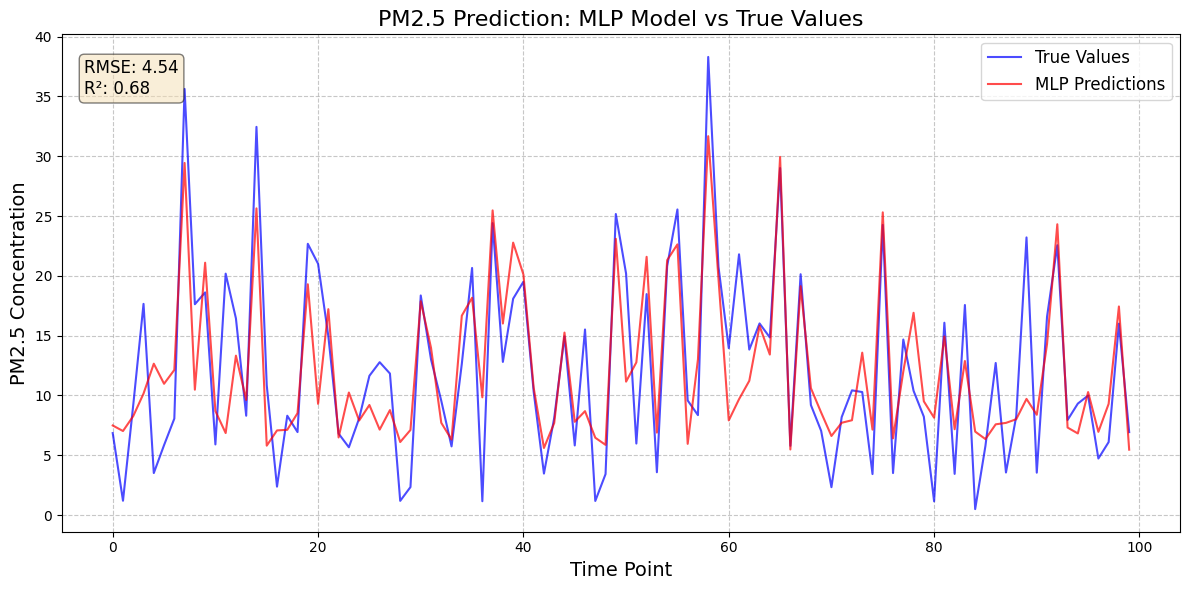

In [ ]:
# Create a time series plot comparing predictions with true values
plt.figure(figsize=(12, 6))

y_test_plot=y_test[:100]
y_pred_plot=y_pred[:100]

# Create an index for the x-axis (representing time points)
time_index = range(len(y_test_plot))

# Plot true values
plt.plot(time_index, y_test_plot.values, 'b-', label='True Values', alpha=0.7)

# Plot predicted values
plt.plot(time_index, y_pred_plot, 'r-', label='MLP Predictions', alpha=0.7)

# Add a legend, title and labels
plt.title('PM2.5 Prediction: MLP Model vs True Values', fontsize=16)
plt.xlabel('Time Point', fontsize=14)
plt.ylabel('PM2.5 Concentration', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add information about model performance
textstr = f'RMSE: {np.sqrt(mean_squared_error(y_test_plot, y_pred_plot)):.2f}\nR²: {r2_score(y_test_plot, y_pred_plot):.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


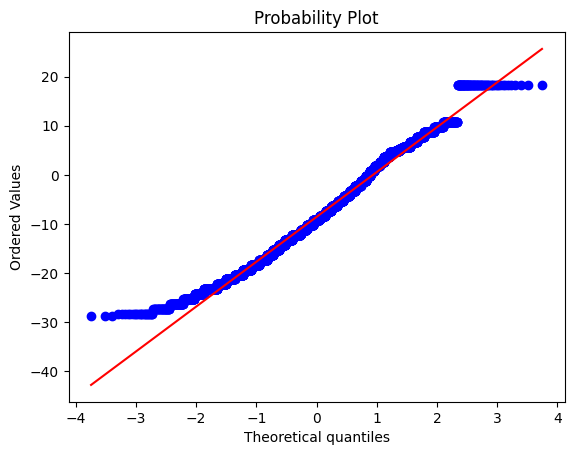

In [27]:
# Plot the QQ plot
errors = y_test - y_pred[0]
stats.probplot(errors, dist="norm", plot=plt)
plt.show()